# Проект для «Викишоп» 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель проекта:
- обучить модель классифицировать комментарии на позитивные и негативные, 
- постройте модель со значением метрики качества F1 не меньше 0.75. 


В ходе работы планируем выполнить следующие шаги:
 1. Загрузка и предобработка данных.
 2. Обучение моделей.
 3. Вывод.

##  1. Загрузка и предобработка данных.

In [1]:
%load_ext watermark
%watermark -a 'Wiki_shop' -u -d -v -p numpy,pandas,matplotlib,nltk

Author: Wiki_shop

Last updated: 2023-09-26

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

numpy     : 1.24.4
pandas    : 2.0.2
matplotlib: 3.7.1
nltk      : 3.8.1



In [2]:
# выведем необходимые библиотеки для работы
import pandas as pd 
import numpy as np 

from sklearn.pipeline import Pipeline

import re
import ssl
import nltk
import spacy
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score

import time
import warnings

RANDOM_STATE = 12345

warnings.filterwarnings('ignore')

In [3]:
# выведем датасет
df = pd.read_csv('/Users/urvanov_aleksandr/yandex-praktikum/wiki_shop/toxic_comments.csv', 
                 index_col=[0])
df.reset_index(drop= True , inplace= True )
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
print('Количество пропусков в датасете:')
display(df.isna().sum())

Количество пропусков в датасете:


text     0
toxic    0
dtype: int64

In [6]:
print('Количество дупликатов в датасете:')
df.duplicated().sum()

Количество дупликатов в датасете:


0

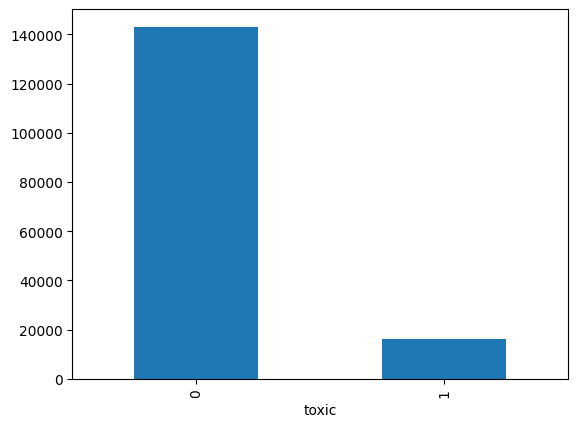

In [7]:
# проверяем распределение классов 
df['toxic'].value_counts().plot.bar();

In [8]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [9]:
# функция для очистки датасета 
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [10]:
tqdm.pandas()
# очищаем от ненужных символов и прочего
df['text'] = df['text'].progress_apply(clean_text)

100%|████████████████████████████████| 159292/159292 [00:04<00:00, 39231.92it/s]


In [11]:
# лемматизация, токенизация
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def spacy_lemm(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

df['lemm_text'] = df['text'].progress_apply(spacy_lemm)

100%|██████████████████████████████████| 159292/159292 [13:26<00:00, 197.56it/s]


In [12]:
# удаляем исходный столбец
df = df.drop(['text'], axis=1)

In [13]:
display(df.head())

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I be see...
2,0,hey man I be really not try to edit war it jus...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...


### Вывод

Датасет загружен, с помощью регулярных выражений обработали текст для дальнейшего исследования. Проведена лемматизаци и токенизация текста. Пропуски и дубликаты не выявлены. Около 10% описаний имеют токсичный характер.

## 2. Обучение моделей.

In [14]:
# выделяем целевой признак и признаки:
features = df.drop('toxic', axis=1)
target = df['toxic']

In [15]:
# выделяем 50% данных для обучающей выборки, остальные данные для тестовой
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                      test_size =0.5,
                                                      random_state=RANDOM_STATE)


In [16]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [17]:
# выгружаем английские стоп-слова
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/urvanov_aleksandr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Будем использовать четыре модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier и LGBMClassifier.

LogisticRegression

In [18]:
%%time

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))])

lr_params = {'clf__C': [10],
             'clf__class_weight': ['balanced']}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=lr_params, cv=3, scoring='f1',
                       n_jobs=-1)

lr_grid = lr_grid.fit(X_train['lemm_text'], y_train)

lr_score = lr_grid.best_score_


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


CPU times: user 10.2 s, sys: 588 ms, total: 10.8 s
Wall time: 19.5 s


In [19]:
print('F1 модели LogisticRegression:', lr_score)

F1 модели LogisticRegression: 0.7687827623744137


________

Модель RandomForestClassifier

In [20]:
%%time

rfc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])

rfc_params = {'clf__class_weight': ['balanced']}

rfc_grid = GridSearchCV(estimator=rfc_pipe, param_grid=rfc_params, cv=3, verbose=1,
                        scoring='f1', n_jobs=-1, refit=False)

rfc_grid.fit(X_train['lemm_text'], y_train)

rfc_score = rfc_grid.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


CPU times: user 75.7 ms, sys: 93.7 ms, total: 169 ms
Wall time: 1min 47s


In [21]:
print('F1 модели RandomForestClassifier:', rfc_score)

F1 модели RandomForestClassifier: 0.591738209789651


____

Модель CatBoostClassifier

In [22]:
%%time

cbc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', CatBoostClassifier(random_state=RANDOM_STATE))])

cbc_params = {'clf__n_estimators': [20],
                'clf__learning_rate': [0.25]}

cbc_grid = GridSearchCV(estimator=cbc_pipe, param_grid=cbc_params, cv=3, verbose=1,
                        scoring='f1', n_jobs=-1, refit=False)

cbc_grid.fit(X_train['lemm_text'], y_train)

cbc_score = cbc_grid.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


CPU times: user 73.8 ms, sys: 124 ms, total: 198 ms
Wall time: 1min 5s


In [23]:
print('F1 для  модели CatBoostClassifier:', cbc_score)

F1 для  модели CatBoostClassifier: 0.6186024503189996


_______

Модель LGBMClassifier

In [24]:
%%time

lgc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=RANDOM_STATE))])

lgc_params = {  'clf__n_estimators': [200],
                'clf__learning_rate': [0.25],
                 'clf__max_depth': [-1]}

lgc_grid = GridSearchCV(estimator=lgc_pipe, param_grid=lgc_params, cv=3, verbose=1,
                        scoring='f1', n_jobs=-1, refit=False)

lgc_grid.fit(X_train['lemm_text'], y_train)

lgc_score = lgc_grid.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.4820608	total: 2.07s	remaining: 39.4s
1:	learn: 0.3659224	total: 4.27s	remaining: 38.4s
2:	learn: 0.3055827	total: 6.53s	remaining: 37s
3:	learn: 0.2706630	total: 8.78s	remaining: 35.1s
4:	learn: 0.2504185	total: 10.8s	remaining: 32.5s
5:	learn: 0.2376037	total: 12.8s	remaining: 30s
6:	learn: 0.2284097	total: 15s	remaining: 27.9s
7:	learn: 0.2194073	total: 17.3s	remaining: 26s
8:	learn: 0.2145763	total: 19.5s	remaining: 23.9s
9:	learn: 0.2097665	total: 21.6s	remaining: 21.6s
10:	learn: 0.2063145	total: 23.6s	remaining: 19.3s
11:	learn: 0.2029350	total: 25.7s	remaining: 17.1s
12:	learn: 0.1981094	total: 27.6s	remaining: 14.8s
13:	learn: 0.1954563	total: 29.6s	remaining: 12.7s
14:	learn: 0.1934021	total: 31.5s	remaining: 10.5s
15:	learn: 0.1905621	total: 33.7s	remaining: 8.41s
16:	learn: 0.1887495	total: 35.7s	remaining: 6.3s
17:	learn: 0.1869962	total: 37.7s	remaining: 4.18s
18:	learn: 0.1855694	total: 40.1s	remainin

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


CPU times: user 79.8 ms, sys: 98.1 ms, total: 178 ms
Wall time: 29.7 s


In [25]:
print('F1 модели LGBMClassifier:', lgc_score)

F1 модели LGBMClassifier: 0.7631747424775067


In [26]:
# сводная таблица по показателю F1:
index = ['LogisticRegression',
         'RandomForestClassifier',
         'CatBoostClassifier',
         'LGBMClassifier']

data = {'F1':  [lr_score,
                rfc_score,
                cbc_score,
                lgc_score]}

data = pd.DataFrame(data=data, index=index)


data.sort_values(by = 'F1', ascending=False)

,F1
LogisticRegression,0.768783
LGBMClassifier,0.763175
CatBoostClassifier,0.618602
RandomForestClassifier,0.591738


Лучшей моделью  по требуемому параметру является LogisticRegression.

In [27]:
# тестирование лучшей модели на тестовой выборке 
y_pred = lr_grid.predict(X_test['lemm_text'])

In [28]:
print('F1 на тестовой выборке', f1_score(y_pred, y_test))

F1 на тестовой выборке 0.7761506276150627


## 3. Вывод

В ходе работы было выполнено:

 1. Загрузили и обработали текст с помощью регулярных выражений.
 2. Проверили данные на пропуски и дубликаты. 
 3. Провели лемматизацию и токенизацию текста. 
 4. Выполнено сравнение 4-х моделей LogisticRegression, RandomForestClassifier, CatBoostClassifier и LGBMClassifier.
 5. Выбрана лучшая модель по результатам метрики F1.
 
Лучшей моделью по требуемому параметру является LogisticRegression. F1 на тренировочной выборке = 0,7687. F1 на тестовой выборке = 0,7761. Для заказчика однозначно рекомендую использовать эту модель для классификации комментариев на позитивные и негативные. Поствленная задача по значению метрики модели F1 > 0.75, достигнута. 
